In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

from scripts.proj1_helpers import *
from scripts.implementations import *
from scripts.plots import *

import numpy as np
import pandas as pd

# Data exploration 

In [21]:
train = pd.read_csv('../data/train.csv')
print(train.info())

train = train.set_index('Id')
train_tx = train[list(filter(lambda c: c != 'Prediction', list(train)))]
train_y = train['Prediction']

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Id                           250000 non-null  int64  
 1   Prediction                   250000 non-null  object 
 2   DER_mass_MMC                 250000 non-null  float64
 3   DER_mass_transverse_met_lep  250000 non-null  float64
 4   DER_mass_vis                 250000 non-null  float64
 5   DER_pt_h                     250000 non-null  float64
 6   DER_deltaeta_jet_jet         250000 non-null  float64
 7   DER_mass_jet_jet             250000 non-null  float64
 8   DER_prodeta_jet_jet          250000 non-null  float64
 9   DER_deltar_tau_lep           250000 non-null  float64
 10  DER_pt_tot                   250000 non-null  float64
 11  DER_sum_pt                   250000 non-null  float64
 12  DER_pt_ratio_lep_tau         250000 non-null  float64
 13 

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
Id,,,,,,,,,,,,,,,,,,,,,
100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


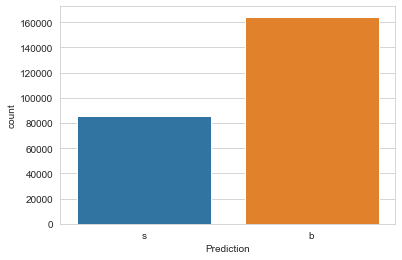

In [45]:
pred_cat = list(train['Prediction'].unique())
num_cat = len(pred_cat)

fig, ax = plt.subplots()

sns.countplot(x='Prediction', data=train, ax=ax);

- Unbalanced classes
- The relevant class s (signal) is underrepresented

## Pick some random variable for visualisations to examine distribution and class imbalance

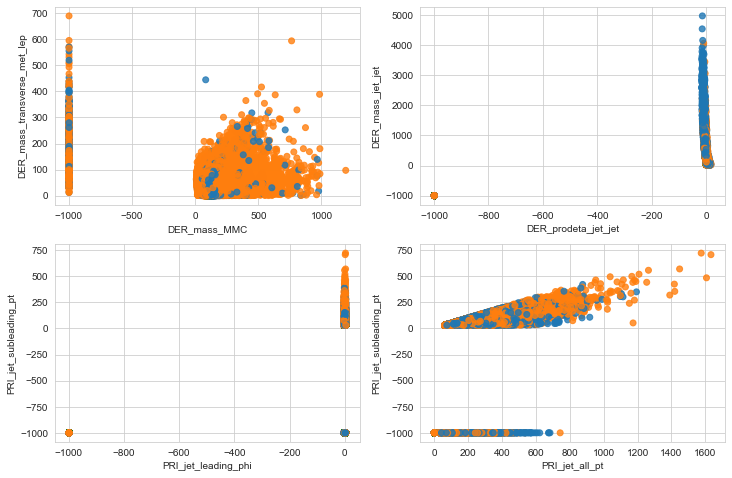

In [40]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

catcolors = {ct: cc for ct, cc in zip(pred_cat, colors[:num_cat])}

x = 'DER_mass_MMC'
y = 'DER_mass_transverse_met_lep'
ax[0].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[0].set(xlabel=x, ylabel=y)

x = 'DER_prodeta_jet_jet'
y = 'DER_mass_jet_jet'
ax[1].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[1].set(xlabel=x, ylabel=y);

x = 'PRI_jet_leading_phi'
y = 'PRI_jet_subleading_pt'
ax[2].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[2].set(xlabel=x, ylabel=y);

x = 'PRI_jet_all_pt'
y = 'PRI_jet_subleading_pt'
ax[3].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[3].set(xlabel=x, ylabel=y);

- Need to do some outlier cleaning or find robust method
- No obvious correlations between single features and target varible
- Dataset seems highly skewed

# Feature Selection

## 0 Feature importance analysis

In [35]:
train['Prediction_enc'] = train['Prediction'].map({'s': 1, 'b':-1})
corr_y = train.corr()['Prediction_enc']

corr_y = corr_y.drop('Prediction_enc')

<AxesSubplot:>

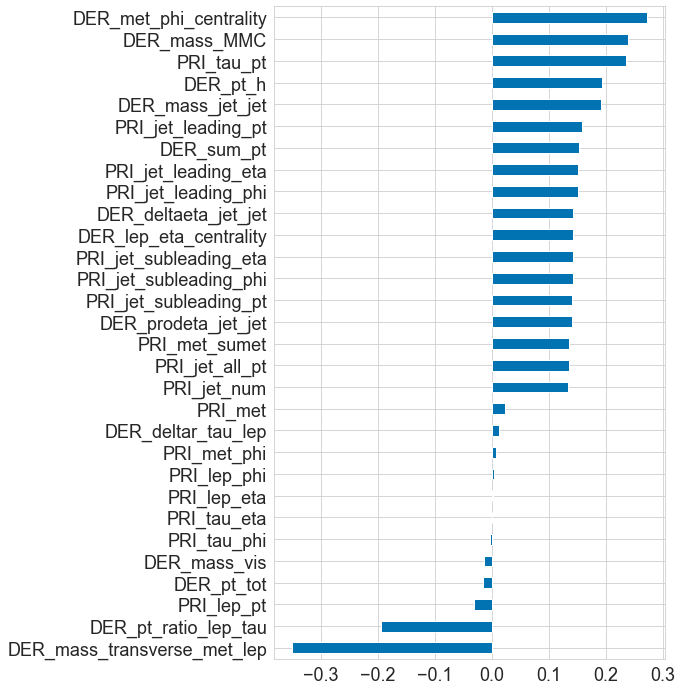

In [37]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 12))

corr_y.sort_values().plot.barh()

In [69]:
least_informative = list(abs(corr_y).sort_values(ascending=False)[20:].index)
train.drop(least_informative + ['Prediction_enc'], axis=1).to_csv('../data/train_top_twenty.csv')

test = pd.read_csv('../data/test.csv')
test = test.set_index('Id')
test.drop(least_informative, axis=1).to_csv('../data/test_top_twenty.csv')

## 1 Find highly-correlated features

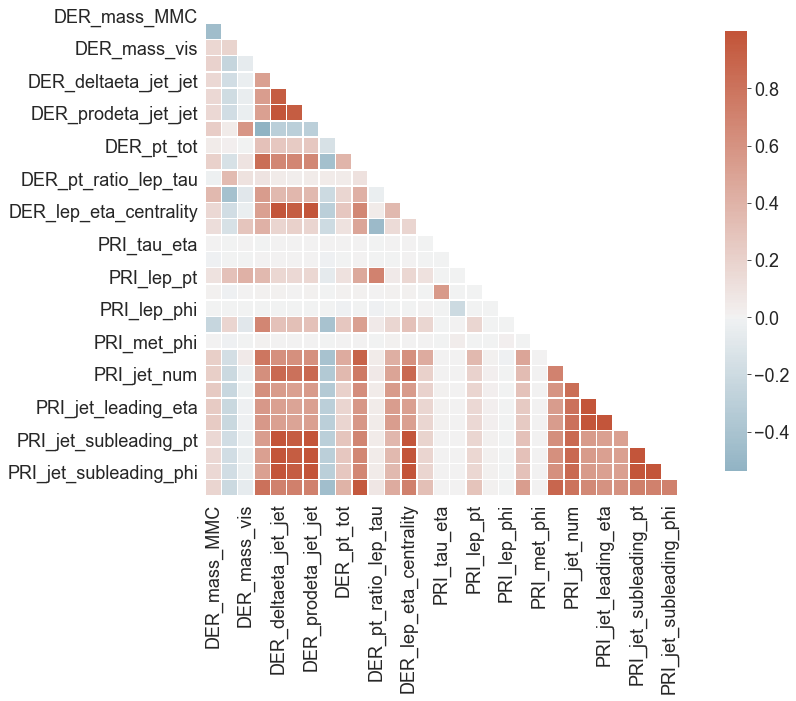

In [38]:
corr_tx = train_tx.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9});

In [43]:
corr_tx.shape

(30, 30)

In [46]:
corr_tx

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
DER_mass_MMC,1.000000,-0.455755,0.168548,0.198765,0.162661,0.160524,0.162521,0.228105,0.045826,0.201464,...,0.007411,0.221984,0.221078,0.250158,0.247083,0.247078,0.162836,0.162614,0.162609,0.185372
DER_mass_transverse_met_lep,-0.455755,1.000000,0.190109,-0.249116,-0.176386,-0.190392,-0.175942,0.043251,0.017758,-0.146837,...,-0.015925,-0.167811,-0.210537,-0.229674,-0.220370,-0.220355,-0.176837,-0.176231,-0.176225,-0.210009
DER_mass_vis,0.168548,0.190109,1.000000,-0.062562,-0.032251,-0.040620,-0.032126,0.579712,-0.000702,0.088685,...,-0.001467,0.053300,-0.026860,-0.019151,-0.013749,-0.013742,-0.033188,-0.032202,-0.032206,-0.052902
DER_pt_h,0.198765,-0.249116,-0.062562,1.000000,0.523664,0.534531,0.523639,-0.539379,0.310501,0.832733,...,0.008585,0.782547,0.623401,0.621599,0.564898,0.564894,0.531647,0.523714,0.523703,0.808616
DER_deltaeta_jet_jet,0.162661,-0.176386,-0.032251,0.523664,1.000000,0.946045,0.999981,-0.299076,0.270878,0.671996,...,0.005245,0.619100,0.867521,0.545027,0.521657,0.521664,0.999346,0.999995,0.999996,0.712446
DER_mass_jet_jet,0.160524,-0.190392,-0.040620,0.534531,0.946045,1.000000,0.944443,-0.303751,0.247771,0.680700,...,0.005167,0.617057,0.814191,0.521645,0.493233,0.493241,0.947652,0.945505,0.945507,0.719962
DER_prodeta_jet_jet,0.162521,-0.175942,-0.032126,0.523639,0.999981,0.944443,1.000000,-0.299083,0.271435,0.672158,...,0.005254,0.619388,0.867741,0.545022,0.521653,0.521661,0.999347,0.999988,0.999989,0.712620
DER_deltar_tau_lep,0.228105,0.043251,0.579712,-0.539379,-0.299076,-0.303751,-0.299083,1.000000,-0.148081,-0.432603,...,-0.001570,-0.407002,-0.347904,-0.335851,-0.304161,-0.304145,-0.303416,-0.299107,-0.299101,-0.448737
DER_pt_tot,0.045826,0.017758,-0.000702,0.310501,0.270878,0.247771,0.271435,-0.148081,1.000000,0.381160,...,0.002515,0.448925,0.360409,0.202920,0.186564,0.186590,0.279203,0.271100,0.271091,0.403382
DER_sum_pt,0.201464,-0.146837,0.088685,0.832733,0.671996,0.680700,0.672158,-0.432603,0.381160,1.000000,...,0.006712,0.904481,0.758503,0.638796,0.578616,0.578621,0.687465,0.672125,0.672114,0.965628


In [51]:
w = np.arange(9) - 4
lambda_ = .8
lambda_ * sum(abs(w))

16.0

In [53]:
lambda_ * np.sign(w)

array([-0.8, -0.8, -0.8, -0.8,  0. ,  0.8,  0.8,  0.8,  0.8])